## Colab Setup

In [ ]:
# For Colab (follow instructions at https://github.com/johnlyzhou/spike-sorting for local installation)

from google.colab import drive
from IPython.display import clear_output 

# Install packages and requirements
!git clone https://github.com/johnlyzhou/spike-sorting.git
%cd spike-sorting
!pip install -r requirements.txt
!pip install -e .
clear_output()

# Download sample waveform templates
!gdown --id 1FY86UUkV-QdPpAMQGzNiU-wN3W9dtPLo -O /content/spike-sorting/data/raw/templates_yass.npy 

In [1]:
from pathlib import Path

import numpy as np

from src.data.preprocess_templates import ( 
    get_max_chan_temps, 
    take_channel_range, 
    localize_wfs
)
from src.data.make_datasets import (
    featurization_dataset, 
    positional_invariance_dataset, 
    clustering_dataset
)
from src.evaluation.visualize import plot_templates

## Load Data

In [2]:
REPO_PATH = "/Users/johnzhou/research/spike-sorting"
RAW_DATA_DIR = Path(f"{REPO_PATH}/data/raw")
PROCESS_DATA_DIR = Path(f"{REPO_PATH}/data/processed")

In [3]:
# Cleaned and denoised templates
templates_fname = "templates_yass.npy"
templates_fpath = Path(f"{RAW_DATA_DIR}/{templates_fname}")
templates = np.load(templates_fpath)
num_templates, num_timesteps, num_chans = templates.shape
print(f"{num_templates} templates, {num_timesteps} timesteps, {num_chans} channels.")

# Probe geometry
geom_fname = "channel_map_np2.npy"
geom_fpath = Path(f"{RAW_DATA_DIR}/{geom_fname}")
geom_array = np.load(geom_fpath)

# Raw recordings for noise
raw_10s_path = f"{RAW_DATA_DIR}/ten_np2_seconds.npy"

170 templates, 121 timesteps, 384 channels.


## Data Preprocessing

### Identify and Remove Bad Templates

(170, 121, 384)
Template 0


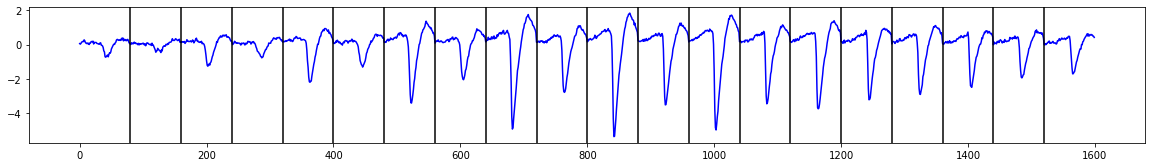

Template 1


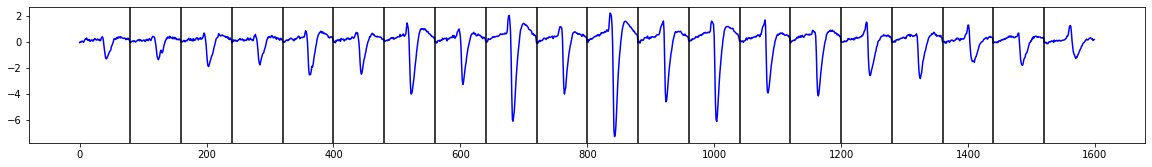

Template 2


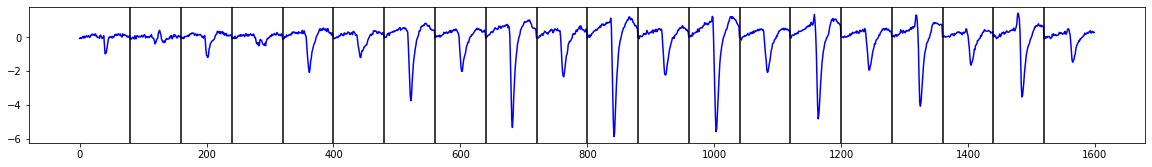

Template 3


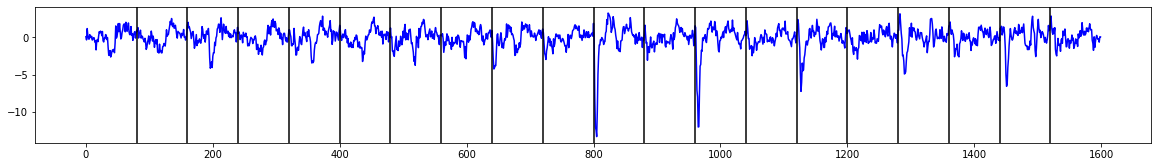

Template 4


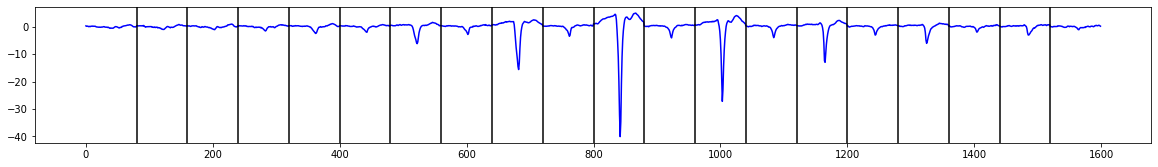

Template 5


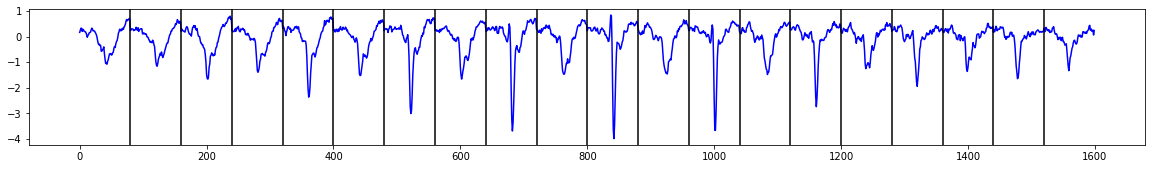

Template 6


In [ ]:
# Number of channels to take around max channel
n_channels = 20
channel_positions = geom_array[:n_channels]

# Look at each template and note which ones are "bad", i.e. don't look like typical spikes
print(templates.shape)
plot_templates(templates, n_channels=n_channels, n_templates=10)

In [5]:
# Remove the bad templates by index
bad_template_idxs = [3, 6, 27, 29, 32, 35, 36, 56, 57, 58, 59, 62, 63, 64, 74, 78, 79, 80, 85, 91, 92, \
    101, 107, 109, 110, 111, 118, 119, 121, 145, 150, 151, 152, 157, 159, 164, 165, 169]
good_templates = np.delete(templates, bad_template_idxs, axis=0)
print(f"{good_templates.shape[0]} good templates remaining.")

132 good templates remaining.


### Take Channel Window and Localize Templates

In [6]:
# Take the specified number of channels around the max channel
templates_chans, templates_ptp_chans = take_channel_range(good_templates, n_channels_loc=n_channels)
# Localize each template to a predicted position
template_positions = localize_wfs(templates_ptp_chans, geom_array)

100%|██████████████████████████████████████████| 132/132 [00:01<00:00, 120.32it/s]


## Generate Synthetic Datasets

In [7]:
# Gamma distribution parameters for alpha position variable.
a, loc, scale = 3, 100, 500

### Featurization Dataset

In [8]:
featurize_train_experiment_name = "featurization_train"
featurize_val_experiment_name = "featurization_val"

train_frac = 0.8
n_samples = 100000

n_train_samples = round(n_samples * train_frac)
n_val_samples = round(n_samples * (1 - train_frac))

# Training data
featurization_dataset(
    templates_chans, template_positions, channel_positions, a, loc, scale, n_samples=n_train_samples, 
    noise_path=raw_10s_path,
    experiment_data_dir=PROCESS_DATA_DIR, 
    experiment_name=featurize_train_experiment_name
)
# Validation data
featurization_dataset(
    templates_chans, template_positions, channel_positions, a, loc, scale, n_samples=n_val_samples, 
    noise_path=raw_10s_path, 
    experiment_data_dir=PROCESS_DATA_DIR, 
    experiment_name=featurize_val_experiment_name
)

Adding noise to dataset


100%|██████████████████████████████████████| 80000/80000 [04:59<00:00, 267.45it/s]


Saving templates to folder /Users/johnzhou/research/spike-sorting/data/processed/featurization_train, array of shape: (80000, 20, 121)
Saving predicted PTPs to folder /Users/johnzhou/research/spike-sorting/data/processed/featurization_train, array of shape: (80000, 20)
Saving positions to folder /Users/johnzhou/research/spike-sorting/data/processed/featurization_train, array of shape: (80000, 4)
Saving unit indices to folder /Users/johnzhou/research/spike-sorting/data/processed/featurization_train, array of shape: (80000,)
Adding noise to dataset


100%|██████████████████████████████████████| 20000/20000 [00:48<00:00, 416.50it/s]


Saving templates to folder /Users/johnzhou/research/spike-sorting/data/processed/featurization_val, array of shape: (20000, 20, 121)
Saving predicted PTPs to folder /Users/johnzhou/research/spike-sorting/data/processed/featurization_val, array of shape: (20000, 20)
Saving positions to folder /Users/johnzhou/research/spike-sorting/data/processed/featurization_val, array of shape: (20000, 4)
Saving unit indices to folder /Users/johnzhou/research/spike-sorting/data/processed/featurization_val, array of shape: (20000,)


### Clustering Dataset

In [33]:
num_clusters = 20
num_samples_per_cluster = 1000
cluster_experiment_name = "clusters_k={}".format(num_clusters)

clustering_dataset(templates_chans, template_positions, channel_positions, a, loc, scale, n_clusters=num_clusters, 
                   num_samples_per_cluster=num_samples_per_cluster, 
                   noise_path=raw_10s_path,
                   experiment_data_dir=PROCESS_DATA_DIR, 
                   experiment_name=cluster_experiment_name)

Adding noise to dataset


100%|███████████████████████████████████████████| 20/20 [00:08<00:00,  2.31it/s]


Saving templates to folder /Users/johnzhou/research/spike-sorting/data/processed/clusters_k=20, array of shape: (20000, 20, 121)
Saving predicted PTPs to folder /Users/johnzhou/research/spike-sorting/data/processed/clusters_k=20, array of shape: (20000, 20)
Saving positions to folder /Users/johnzhou/research/spike-sorting/data/processed/clusters_k=20, array of shape: (20000, 4)
Saving unit indices to folder /Users/johnzhou/research/spike-sorting/data/processed/clusters_k=20, array of shape: (20000,)


### Positional Invariance Analysis Dataset

In [32]:
position_features = ["x", "z", "y", "alpha"]
vary_samples = 100

for vary_feature in position_features:
    vary_experiment_name = "invariance_analysis_{}".format(vary_feature)
    
    positional_invariance_dataset(
        templates_chans, template_positions, channel_positions, a, loc, scale, vary_feature=vary_feature, 
        n_samples=vary_samples, 
        experiment_data_dir=PROCESS_DATA_DIR, 
        experiment_name=vary_experiment_name
    )

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1325.57it/s]


Saving templates to folder /Users/johnzhou/research/spike-sorting/data/processed/invariance_analysis_x, array of shape: (100, 20, 121)
Saving predicted PTPs to folder /Users/johnzhou/research/spike-sorting/data/processed/invariance_analysis_x, array of shape: (100, 20)
Saving positions to folder /Users/johnzhou/research/spike-sorting/data/processed/invariance_analysis_x, array of shape: (100, 4)
Saving unit indices to folder /Users/johnzhou/research/spike-sorting/data/processed/invariance_analysis_x, array of shape: (100,)


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1461.84it/s]


Saving templates to folder /Users/johnzhou/research/spike-sorting/data/processed/invariance_analysis_z, array of shape: (100, 20, 121)
Saving predicted PTPs to folder /Users/johnzhou/research/spike-sorting/data/processed/invariance_analysis_z, array of shape: (100, 20)
Saving positions to folder /Users/johnzhou/research/spike-sorting/data/processed/invariance_analysis_z, array of shape: (100, 4)
Saving unit indices to folder /Users/johnzhou/research/spike-sorting/data/processed/invariance_analysis_z, array of shape: (100,)


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1692.62it/s]


Saving templates to folder /Users/johnzhou/research/spike-sorting/data/processed/invariance_analysis_y, array of shape: (100, 20, 121)
Saving predicted PTPs to folder /Users/johnzhou/research/spike-sorting/data/processed/invariance_analysis_y, array of shape: (100, 20)
Saving positions to folder /Users/johnzhou/research/spike-sorting/data/processed/invariance_analysis_y, array of shape: (100, 4)
Saving unit indices to folder /Users/johnzhou/research/spike-sorting/data/processed/invariance_analysis_y, array of shape: (100,)


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1484.76it/s]


Saving templates to folder /Users/johnzhou/research/spike-sorting/data/processed/invariance_analysis_alpha, array of shape: (100, 20, 121)
Saving predicted PTPs to folder /Users/johnzhou/research/spike-sorting/data/processed/invariance_analysis_alpha, array of shape: (100, 20)
Saving positions to folder /Users/johnzhou/research/spike-sorting/data/processed/invariance_analysis_alpha, array of shape: (100, 4)
Saving unit indices to folder /Users/johnzhou/research/spike-sorting/data/processed/invariance_analysis_alpha, array of shape: (100,)
